# Classifying Damage Level Disaster-Induced Images Via Computer Vision


https://www.overleaf.com/project/662998cb25dcfcdb03e5d57a

Shirley Li, Kofi Mireku, Brent Thorne

Data200S, UC Berkeley MSSE

**Summary and Introduction**

This notebook serves as a repository for collecting observations and results. It does not represent refinements to models and analyses conducted outside this notebook.

    Model Selection:
        The approach integrates predictive and inferential elements.
        Two model choices:
            Convolutional Neural Network (CNN): Effective for processing grid-like data (e.g., images) and extracting hierarchical features.
            Singular Value Decomposition (SVD) or Principal Component Analysis (PCA): Computationally efficient, providing low-dimensional representations for large, high-dimensional datasets.

    Hyperparameter Tuning:
        The model does not require extensive tuning due to the use of convolutional layers.
        Unlike Support Vector Machines, CNNs perform effectively without extensive hyperparameter adjustments.

    Feature Engineering:
        Image size selection within the interquartile range ensures a balanced and representative sample. (used in initial model, current dev is with weighted bottleneck, w/vgg16)
        Augmentation techniques (flipping, rotation) enhance training data diversity.  (used in initial model, weighted bottleneck for vgg16).
        Resizing images to a common aspect ratio reduces model complexity.

    Cross-Validation:
        Categorical cross-entropy loss function used during cross-validation.
        F1 score is the primary metric for model comparison.
        Precision, recall, and R2 scores provide comprehensive evaluation.

    Bias-Variance Tradeoff and Overfitting:
        Precision, recall, F1 scores, and R2 scores assess bias-variance tradeoff.
        Monitoring training and validation loss helps detect overfitting.
        SVD model uses condition numbers to manage complexity.

    Model Improvement:
        Address label imbalance by augmenting or dropping data based on outcomes.
        Employ k-fold cross-validation for performance estimation on unseen data.
        Use weighted bottleneck and vgg16.
        Explore essemble VGG6, CNN, and SVG. 

    Further Extensions:
        Investigating visualizations of intermediate activations in CNNs.
        Interpreting dimensions of latent space using principal components.
        Exploring Synthetic Minority Oversampling Technique (SMOTE) for data augmentation.


## Library Import and Environment Configuration

In [1]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    read_files_from_zip,
    data2pd,
    show_balance,
    load_model_data,
    save_model_data,
)



2024-05-06 10:48:02.816538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%%time
data_dir = '../data'

# Pickle out data to speed this up
train_df, test_df = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/train_df.pkl")
    & os.path.isfile(f"{data_dir}/test_df.pkl")
):
    train_df = pd.read_pickle(f"{data_dir}/train_df.pkl")
    test_df = pd.read_pickle(f"{data_dir}/test_df.pkl")
else:
    # Load Test Images
    test_data_images = read_files_from_zip(
        data_file, r"(test)_images_([\w-]*)\.npz"
    )

    # Load Train Images and Labels
    train_data_images = read_files_from_zip(
        data_file, r"satellite-image-data/([\w-]*)/(train)_images\.npz"
    )
    train_data_labels = read_files_from_zip(
        data_file, r"satellite-image-data/([\w-]*)/(train)_labels\.npy"
    )

    # Convert to Dataframe
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

    # Pickle DataFrame
    train_df.to_pickle(f"{data_dir}/train_df.pkl")
    test_df.to_pickle(f"{data_dir}/test_df.pkl")

    # Clean up
    del test_data_images
    del train_data_images
    del train_data_labels

CPU times: user 469 ms, sys: 667 ms, total: 1.14 s
Wall time: 1.77 s


In [3]:
# Configure system type
COLAB = False

# Set data and system paths
if COLAB:
    import sys
    from google.colab import drive

    drive.mount("/content/drive")
    path = "/content/drive/My Drive/Colab Notebooks/grad_project"
    data_dir = f"{path}/data"
    sys.path.insert(
        0, f"{path}/Source"
    )  # for colab to see local libraries
else:
    data_dir = f"../data"
    path = "."

# Set Date Source
data_file = f"{data_dir}/sp24_grad_project_data.zip"
figure_path = f"{path}/../figures"

# Set Default Image Size
SIZE = 120

## Task A

### Feature Engineering (Task A)

In [4]:
# Select Dataset for Disaster Type Classification
train_type_df = train_df[
    ((train_df.type == "fire") | (train_df.type == "flood"))
]  # & (train_df.label != 0)]
test_type_df = test_df[
    ((test_df.type == "fire") | (test_df.type == "flood"))
]  # & (test_df.label != 0)]
show_balance(train_type_df)

# Encode labels
def encode_label(type_df):
    type_df = type_df.copy()
    type_df["old_label"] = type_df["label"]
    type_df["label"] = (
        type_df[["type", "old_label"]]
        .apply(
            lambda df: (df["old_label"] + 1)
            if df["type"] == "fire"
            else -(df["old_label"]),
            axis=1,
        )
        .astype("int")
        + 3
    )
    return type_df


train_type_df = encode_label(train_type_df)

show_balance(train_type_df)
train_type_df.shape, test_type_df.shape

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   4        7204
       7        1064
       5          69
       6          43
flood  3        6734
       2         114
       1          97
       0          59
Name: count, dtype: int64

((15384, 5), (3847, 3))

In [5]:
# Verify class labels
unique_labels = np.unique(train_type_df["label"])
expected_indices = np.arange(8)  # Indices for 8 classes (0 to 7)

if not np.array_equal(unique_labels, expected_indices):
    print(
        "Class labels do not match expected indices. Please verify your labels."
    )

In [6]:
unique_labels, expected_indices

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

### Model CNN, ResNet50 (Task A)

In [7]:
%%time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

SIZE = 120

def resize_images(df, size=(SIZE, SIZE)):
    resized_images = []
    for i in range(len(df)):
        img = df['image'].iloc[i]
        #img_resized = cv2.resize(img, size)/255.0  # for positive definateness
        img_resized = cv2.resize(img, size, interpolation= cv2.INTER_LINEAR)/255.0
        #img_resized = img_resized.flatten() # Flatten the images
        resized_images.append(img_resized)
    return np.array(resized_images)


# Prepare data
df = train_type_df

m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

X_train = resize_images(m_train_df)  # use image resizing and scaling
Y_train = m_train_df["label"].astype(int)

X_val = resize_images(m_val_df)  # use image resizing and scaling
Y_val = m_val_df["label"].astype(int)

CPU times: user 4.11 s, sys: 1.35 s, total: 5.45 s
Wall time: 5.51 s


In [8]:
dnn_model = keras.Sequential()
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(SIZE,SIZE,3),
pooling='avg',classes=8,
weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

In [9]:
from tensorflow.python.keras.layers import Dense, Flatten

dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(8, activation='softmax'))

In [10]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 256)               524544    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 8)                 2056      
 apper)                                                          
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
___________

In [11]:
from tensorflow.keras.optimizers import Adam
dnn_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
from sklearn.utils import compute_class_weight
# Calculate class weights for imbalanced labels
train_classes = Y_train
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

history = dnn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict,
)

2024-05-06 10:48:22.378613: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2126649600 exceeds 10% of free system memory.


Epoch 1/10
385/385 [==============================] - ETA: 0s - loss: 2.1321 - accuracy: 0.0424

2024-05-06 10:59:07.346829: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 531705600 exceeds 10% of free system memory.


385/385 [==============================] - 796s 2s/step - loss: 2.1321 - accuracy: 0.0424 - val_loss: 1.9897 - val_accuracy: 0.0078
Epoch 2/10
385/385 [==============================] - 825s 2s/step - loss: 2.0877 - accuracy: 0.1142 - val_loss: 2.0798 - val_accuracy: 0.3126
Epoch 3/10
385/385 [==============================] - 826s 2s/step - loss: 2.0789 - accuracy: 0.3500 - val_loss: 2.0695 - val_accuracy: 0.4582
Epoch 4/10
385/385 [==============================] - 870s 2s/step - loss: 2.0739 - accuracy: 0.4718 - val_loss: 2.0399 - val_accuracy: 0.4417
Epoch 5/10
385/385 [==============================] - 853s 2s/step - loss: 2.0679 - accuracy: 0.4950 - val_loss: 2.0147 - val_accuracy: 0.6594
Epoch 6/10
385/385 [==============================] - 839s 2s/step - loss: 2.0556 - accuracy: 0.5007 - val_loss: 1.9838 - val_accuracy: 0.6074
Epoch 7/10
385/385 [==============================] - 833s 2s/step - loss: 2.0432 - accuracy: 0.5741 - val_loss: 1.7732 - val_accuracy: 0.5931
Epoch 8/10

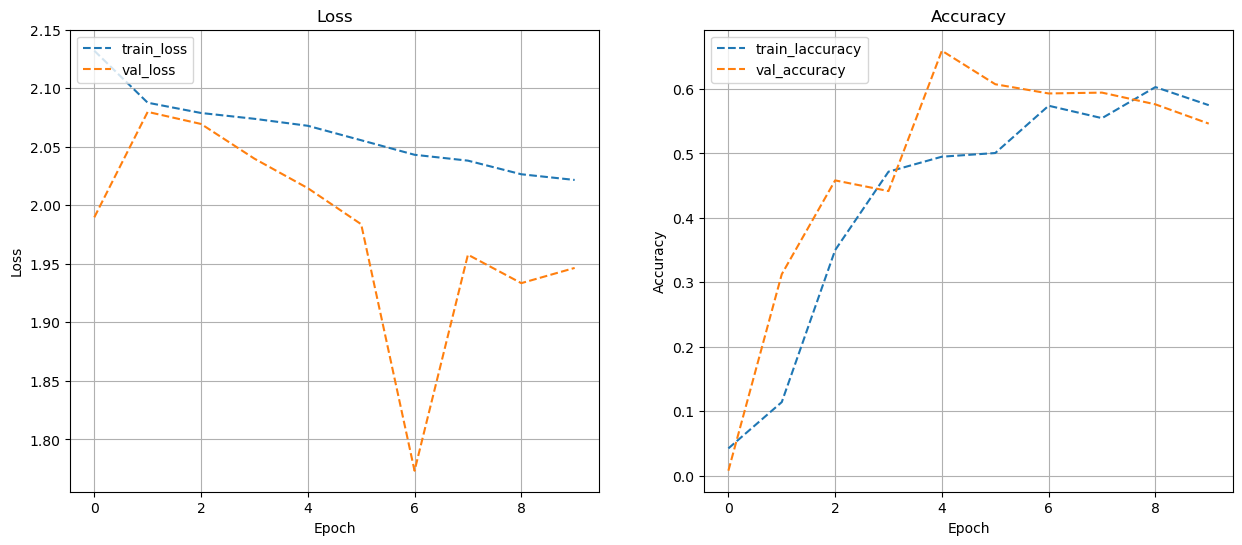

In [16]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, N), history["loss"], label="train_loss", ls="--")
    plt.plot(
        np.arange(0, N), history["val_loss"], label="val_loss", ls="--"
    )
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(0, N),
        history["accuracy"],
        label="train_laccuracy",
        ls="--",
    )
    plt.plot(
        np.arange(0, N),
        history["val_accuracy"],
        label="val_accuracy",
        ls="--",
    )
    # plt.yscale('log')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.grid()

model_history = history
plot_loss(model_history)

In [19]:
def custom_activation(y):
    return np.where(y > 3.5, 1, 0)
    
model = dnn_model
Y_pred = model.predict(X_val)  # much slower making predictions than our custom vgg16
Y_pred = custom_activation(np.argmax(Y_pred, axis=1))
Y_actual = custom_activation(m_val_df["label"].to_numpy())

sum(Y_pred == Y_actual) / len(Y_actual) # Show how did

2024-05-06 13:11:20.385019: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 531705600 exceeds 10% of free system memory.


97/97 [==============================] - 187s 2s/step


0.7065323366915827

              precision    recall  f1-score   support

           0     0.8176    0.4575    0.5867      1401
           1     0.6686    0.9147    0.7725      1676

    accuracy                         0.7065      3077
   macro avg     0.7431    0.6861    0.6796      3077
weighted avg     0.7364    0.7065    0.6879      3077



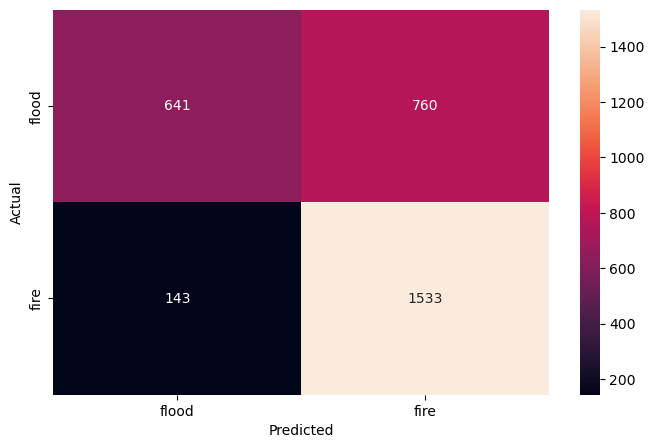

In [20]:
# Evaluate our model based on precision, recall, and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(Y_actual, Y_pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    xticklabels=["flood", "fire"],
    yticklabels=["flood", "fire"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [14]:
assert False

AssertionError: 

### Model CNN, VGG (Task A)

We utilize a pretrained vgg16 network to create bottleneck features then a simple fully-connected model for classification.
This choice was make to accelerate testing of various classification models but reuse of the bottleneck features can take a rather long time (~1.5hrs) to create, while the classification models take only few seconds to train and test.

see also: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
train_type_df.columns

In [ ]:
from tensorflow.keras import backend

backend.clear_session()  # clear model
SIZE =120

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split

# from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120  # Set image size

# Load Our DataFrame
df = train_type_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(
    weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3)
)

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe["image"]):
        img_array = tf.image.resize(
            img_array, (SIZE, SIZE)
        )  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(
            np.expand_dims(img_array, axis=0), verbose=0
        )
        features.append(bottleneck_feature.flatten())
    return np.array(features)


train_features, val_features = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/task_A_train_features.npy")
    & os.path.isfile(f"{data_dir}/task_A_test_features.npy")
    & os.path.isfile(f"{data_dir}/task_A_val_features.npy")
):
    train_features = np.load(f"{data_dir}/task_A_train_features.npy")
    test_features = np.load(f"{data_dir}/task_A_test_features.npy")
    val_features = np.load(f"{data_dir}/task_A_val_features.npy")
else:
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(test_type_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f"{data_dir}/task_A_train_features.npy", train_features)
    np.save(f"{data_dir}/task_A_test_features.npy", test_features)
    np.save(f"{data_dir}/task_A_val_features.npy", val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.01)),
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.0001)),
model.add(Dense(8, activation="softmax"))  # 8 classes

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Calculate class weights for imbalanced labels
train_classes = m_train_df["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = "task_A_vgg16_model_dropout"
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(
        train_features,
        m_train_df["label"],
        validation_data=(val_features, m_val_df["label"]),
        epochs=10,
        batch_size=128,
        class_weight=class_weights_dict,
    )
    # Save, one and done.
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )

#### Model Summary (Task A)

In [ ]:
vgg16.summary()
model.summary()

In [ ]:
# Save model and feature weights
FREEZE = False
if FREEZE:
    model_name = "task_A_vgg16_model"
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )
    np.save(f"{data_dir}/task_A_train_features.npy", train_features)
    np.save(f"{data_dir}/task_A_test_features.npy", test_features)
    np.save(f"{data_dir}/task_A_val_features.npy", val_features)

# train_features = np.load(f'{data_dir}/train_features.npy')
# val_features = np.load(f'{data_dir}/val_features.npy')
train_features.shape, val_features.shape

#### Model Evaluation (Task A)

In [ ]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, N), history["loss"], label="train_loss", ls="--")
    plt.plot(
        np.arange(0, N), history["val_loss"], label="val_loss", ls="--"
    )
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(0, N),
        history["accuracy"],
        label="train_laccuracy",
        ls="--",
    )
    plt.plot(
        np.arange(0, N),
        history["val_accuracy"],
        label="val_accuracy",
        ls="--",
    )
    # plt.yscale('log')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.grid()


plot_loss(model_history)

In [ ]:
# Use Custom Activation
def custom_activation(y):
    return np.where(y > 3.5, 1, 0)

In [ ]:
Y_pred = model.predict(val_features)
# Y_pred = model.predict(train_features)
Y_pred = custom_activation(np.argmax(Y_pred, axis=1))
np.sum(Y_pred, axis=0) / len(Y_pred)
Y_actual = custom_activation(m_val_df["label"].to_numpy())
sum(Y_pred == Y_actual) / len(Y_actual)

In [ ]:
# Evaluate our model based on precision, recall, and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(Y_actual, Y_pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    xticklabels=["flood", "fire"],
    yticklabels=["flood", "fire"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

#### Prediction (Task A)

In [ ]:
# Train on all data...
combined_features = np.concatenate((train_features, val_features), axis=0)
combined_targets = pd.concat([m_train_df["label"], m_val_df["label"]])
combined_features.shape, combined_targets.shape

In [ ]:
# Calculate class weights for imbalanced labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(combined_targets),
    y=train_classes,
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
backend.clear_session()  # clear model
model_history = model.fit(
    combined_features,
    combined_targets.astype(float),
    epochs=11,
    batch_size=128,
    class_weight=class_weights_dict,
)

In [ ]:
# Make prediction based on test data
Y_pred = model.predict(test_features)

prediction = custom_activation(np.argmax(Y_pred, axis=1))
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_flooding-fire_predictions.csv", index=False
)

In [ ]:
np.sum(Y_pred_out, axis=0)  # 0.9586690927995841, 0.96517

#### Predict Using Augmented Data

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(combined_features, combined_targets.astype(int))

In [ ]:
Y_smote.shape, combined_targets.shape

In [ ]:
backend.clear_session()  # clear model
model_history = model.fit(
    X_smote,
    Y_smote,
    epochs=20,
    batch_size=128,
)

In [ ]:
# Make prediction based on test data
Y_pred = model.predict(test_features)

prediction = custom_activation(np.argmax(Y_pred, axis=1))
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_flooding-fire_predictions.csv", index=False
)

## Task B

### Feature Engineering (Task B)

In [ ]:
# Select Dataset for Disaster Leve Classification
train_level_df = train_df[(train_df.type == "hurricane")]
test_level_df = test_df[(test_df.type == "hurricane")]
show_balance(train_level_df)

In [ ]:
train_level_df.type.unique()

In [ ]:
train_level_df.columns

### Model CNN (TaskB)

In [ ]:
backend.clear_session()  # clear model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

# Set image size
SIZE = 120  

# Load Our DataFrame
df = train_level_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (0,1,2,3)

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(
    weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3)
)

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe["image"]):
        img_array = tf.image.resize(
            img_array, (SIZE, SIZE)
        )  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(
            np.expand_dims(img_array, axis=0), verbose=0
        )
        features.append(bottleneck_feature.flatten())
    return np.array(features)


train_features, val_features = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/task_B_train_features.npy")
    & os.path.isfile(f"{data_dir}/task_B_test_features.npy")
    & os.path.isfile(f"{data_dir}/task_B_val_features.npy")
):
    train_features = np.load(f"{data_dir}/task_B_train_features.npy")
    test_features = np.load(f"{data_dir}/task_B_test_features.npy")
    val_features = np.load(f"{data_dir}/task_B_val_features.npy")
else:  # FIXME!!
    m_test_df = test_level_df
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(m_test_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f"{data_dir}/task_B_train_features.npy", train_features)
    np.save(f"{data_dir}/task_B_test_features.npy", test_features)
    np.save(f"{data_dir}/task_B_val_features.npy", val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.01)),
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.0001)),
model.add(Dense(4, activation="softmax"))  # 4 classes

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Calculate class weights for imbalanced labels
train_classes = m_train_df["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = "task_B_vgg16_model_dropout"
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(
        train_features,
        m_train_df["label"].astype(float),
        validation_data=(val_features, m_val_df["label"].astype(float)),
        epochs=11,
        batch_size=128,
        class_weight=class_weights_dict,
    )

    # Save, one and done.
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )

#### Model Summary (Task B)

In [ ]:
vgg16.summary()
model.summary()

#### Model Evaluation (Task B)

In [ ]:
def custom_activation(y):
    return np.argmax(y, axis=1)

In [ ]:
Y_pred = model.predict(val_features)
Y_pred = custom_activation(Y_pred)
Y_actual = m_val_df["label"].astype(int).to_numpy()

In [ ]:
sum(Y_pred == Y_actual) / len(Y_actual)

In [ ]:
class_weights_dict

In [ ]:
plot_loss(model_history)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    xticklabels=["0", "1", "2", "3"],
    yticklabels=["0", "1", "2", "3"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
print(
    classification_report(
        Y_actual, Y_pred, target_names=["0", "1", "2", "3"]
    )
)

#### Prediction (Task B)

In [ ]:
# Train on all data...
combined_features = np.concatenate((train_features, val_features), axis=0)
combined_targets = pd.concat([m_train_df["label"], m_val_df["label"]])

combined_features.shape, combined_targets.shape

In [ ]:
# Calculate class weights for imbalanced labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(combined_targets),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
backend.clear_session()  # clear model

In [ ]:
model_history = model.fit(
    combined_features,
    combined_targets.astype(float),
    epochs=11,
    batch_size=128,
    class_weight=class_weights_dict,
)

In [ ]:
# Make prediction based on test data
Y_pred = model.predict(test_features)
prediction = custom_activation(Y_pred)  # 0.53241 %
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_hurricane-matthew_predictions.csv",
    index=False,
)

In [ ]:
class_weights_dict

#### Predict Using Augmented Data

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(combined_features, combined_targets.astype(int))

In [ ]:
Y_smote.shape, combined_targets.shape

In [ ]:
backend.clear_session()  # clear model
model_history = model.fit(
    X_smote,
    Y_smote,
    epochs=11,
    batch_size=128,
)

In [ ]:
# Make prediction based on test data
Y_pred = model.predict(test_features)
prediction = custom_activation(Y_pred)  
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_hurricane-matthew_predictions_smote.csv",
    index=False,
)